## Movie recommender system with Spark machine learning

In this notebook, we will use **ALS** algorithm from Apache Spark's [MLlib](https://spark.apache.org/docs/latest/mllib-guide.html) library to build a recommender system for movies with a data set from MovieLens.

### MovieLens

MovieLens is a project developed by GroupLens, a research laboratory at the University of Minnesota. MovieLens provides an online movie recommender application that uses anonymously-collected data to improve recommender algorithms. Anyone can try the app for free and get movies recommendations. MovieLens also released several data sets to try out recommendation algorithms.

spark.mllib contains the original API that handles data in RDDs. It's in maintenance mode, but fully supported.
spark.ml contains a newer API for constructing ML pipelines. It handles data in DataFrames. It's being actively enhanced. We will use the spark.ml package in this notebook.

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS #, Rating #, MatrixFactorizationModel

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 1. Creating the Spark Session

In [4]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("movie-recommender-pyspark")
         .getOrCreate())
spark

In [5]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=movie-recommender>

In [6]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

Show the default parallelism factor, which is the default number of partitions if we do not specify one:

In [7]:
print (sc.defaultParallelism)

8


In [8]:
print(sc.getConf().toDebugString())

spark.app.id=local-1542778916473
spark.app.name=movie-recommender
spark.driver.host=MISHER
spark.driver.port=54144
spark.executor.id=driver
spark.master=local[*]
spark.rdd.compress=True
spark.serializer.objectStreamReset=100
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


## 2. Load The Data From a File Into a Dataframe

### 2.1 Loading the Ratings Data Set

In [9]:
ratings_schema = StructType([
    StructField("user_id", ShortType(), nullable=False),
    StructField("movie_id", ShortType(), nullable=False),
    StructField("rating", ByteType(), nullable=False),
    StructField("timestamp", LongType(), nullable=False)]
  )

In [10]:
# load the dats set
ratings_df = spark.read.csv("data/ml-100k/u.data", sep='\t', schema=ratings_schema)
ratings_df = ratings_df.drop('timestamp')
ratings_df.cache()
ratings_df.first()

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

Row(user_id=196, movie_id=242, rating=3)

In [11]:
ratings_df.limit(10).toPandas()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [12]:
ratings_df.printSchema()

root
 |-- user_id: short (nullable = true)
 |-- movie_id: short (nullable = true)
 |-- rating: byte (nullable = true)



### 2.2 Loading the Movies Data Set

In [13]:
movies_schema = StructType([
    StructField("movie_id", ShortType(), nullable=True),
    StructField("title", StringType(), nullable=True),
    StructField("release_date", StringType(), nullable=False),
    StructField("video_release_date", StringType(), nullable=False),
    StructField("imdb_url", StringType(), nullable=False),
    StructField("unknown", ByteType(), nullable=False),
    StructField("action", ByteType(), nullable=False),
    StructField("adventure", ByteType(), nullable=False),
    StructField("animation", ByteType(), nullable=False),
    StructField("childrens", ByteType(), nullable=False),
    StructField("comedy", ByteType(), nullable=False),
    StructField("crime", ByteType(), nullable=False),
    StructField("documentary", ByteType(), nullable=False),
    StructField("drama", ByteType(), nullable=False),
    StructField("fantasy", ByteType(), nullable=False),
    StructField("filmnoir", ByteType(), nullable=False),
    StructField("horror", ByteType(), nullable=False),
    StructField("musical", ByteType(), nullable=False),
    StructField("mystery", ByteType(), nullable=False),
    StructField("romance", ByteType(), nullable=False),
    StructField("scifi", ByteType(), nullable=False),
    StructField("thriller", ByteType(), nullable=False),
    StructField("war", ByteType(), nullable=False),
    StructField("western", ByteType(), nullable=False)]
  )

In [14]:
movies_df = spark.read.csv("data/ml-100k/u.item", sep="|", schema=movies_schema).cache()

In [15]:
movies_df.limit(10).toPandas()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),01-Jan-1995,None,http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Dead%20Man%20Walking%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,None,http://us.imdb.com/M/title-exact?Richard%20III%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [16]:
movies_df.printSchema()

root
 |-- movie_id: short (nullable = true)
 |-- title: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- video_release_date: string (nullable = true)
 |-- imdb_url: string (nullable = true)
 |-- unknown: byte (nullable = true)
 |-- action: byte (nullable = true)
 |-- adventure: byte (nullable = true)
 |-- animation: byte (nullable = true)
 |-- childrens: byte (nullable = true)
 |-- comedy: byte (nullable = true)
 |-- crime: byte (nullable = true)
 |-- documentary: byte (nullable = true)
 |-- drama: byte (nullable = true)
 |-- fantasy: byte (nullable = true)
 |-- filmnoir: byte (nullable = true)
 |-- horror: byte (nullable = true)
 |-- musical: byte (nullable = true)
 |-- mystery: byte (nullable = true)
 |-- romance: byte (nullable = true)
 |-- scifi: byte (nullable = true)
 |-- thriller: byte (nullable = true)
 |-- war: byte (nullable = true)
 |-- western: byte (nullable = true)



## 3. Spark Performance Basics

Spark DataFrames are distributed collections across a cluster of Spark executors. One of the key factors for ensuring that a Spark job is well distributed across the cluster is the number of partitions for a DataFrame.

In [17]:
print("Number of partitions for the movies DataFrame: {0}".format(movies_df.rdd.getNumPartitions()))
print("Number of partitions for the ratings DataFrame: {0}".format(ratings_df.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


Despite the defaultParallelism, the Spark DataFrameReader that we used only used a single Spark partition, which means all subsequent Spark operations would only run on a single executor.

We can run the repartition() method to redistribute the ratings data across multiple partitions. But be aware that repartition can involve a great deal of network bandwidth while data is transfered across the cluster! Because Spark DataFrames are immutable, we have to create a new DataFrame to repartition an existing DataFrame.

Create the repartitionedRatings DataFrame across 10 partitions:

In [18]:
ratings_df = ratings_df.repartition(10).cache()
movies_df = movies_df.repartition(10).cache()
print("Number of partitions for the movies DataFrame: {0}".format(movies_df.rdd.getNumPartitions()))
print("Number of partitions for the ratings DataFrame: {0}".format(ratings_df.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 10
Number of partitions for the ratings DataFrame: 10


**Register the DataFrames as Temporary Views:**

In [19]:
movies_df.createOrReplaceTempView('movies')
ratings_df.createOrReplaceTempView('ratings')

## 4. Basic Data Exploration

In [20]:
print("Number of different users: {0}".format(ratings_df.select('user_id').distinct().count()))

Number of different users: 943


In [21]:
print("Number of different movies: {0}".format(ratings_df.select('movie_id').distinct().count()))

Number of different movies: 1682


In [22]:
(print("Number of movies with at least one rating strictly higher than 4: {0}".format(ratings_df
                                                                                     .filter('rating > 4')
                                                                                     .select('movie_id')
                                                                                     .distinct()
                                                                                     .count())))

Number of movies with at least one rating strictly higher than 4: 1172


In [23]:
ratings_df.select(F.max('movie_id')).show()

+-------------+
|max(movie_id)|
+-------------+
|         1682|
+-------------+



In [24]:
ratings_df.select(F.max('user_id')).show()

+------------+
|max(user_id)|
+------------+
|         943|
+------------+



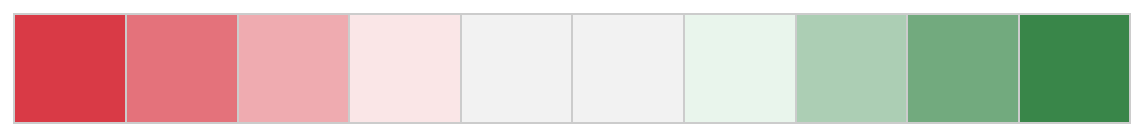

In [25]:
sns.palplot(sns.diverging_palette(10, 133, sep=80, n=10))

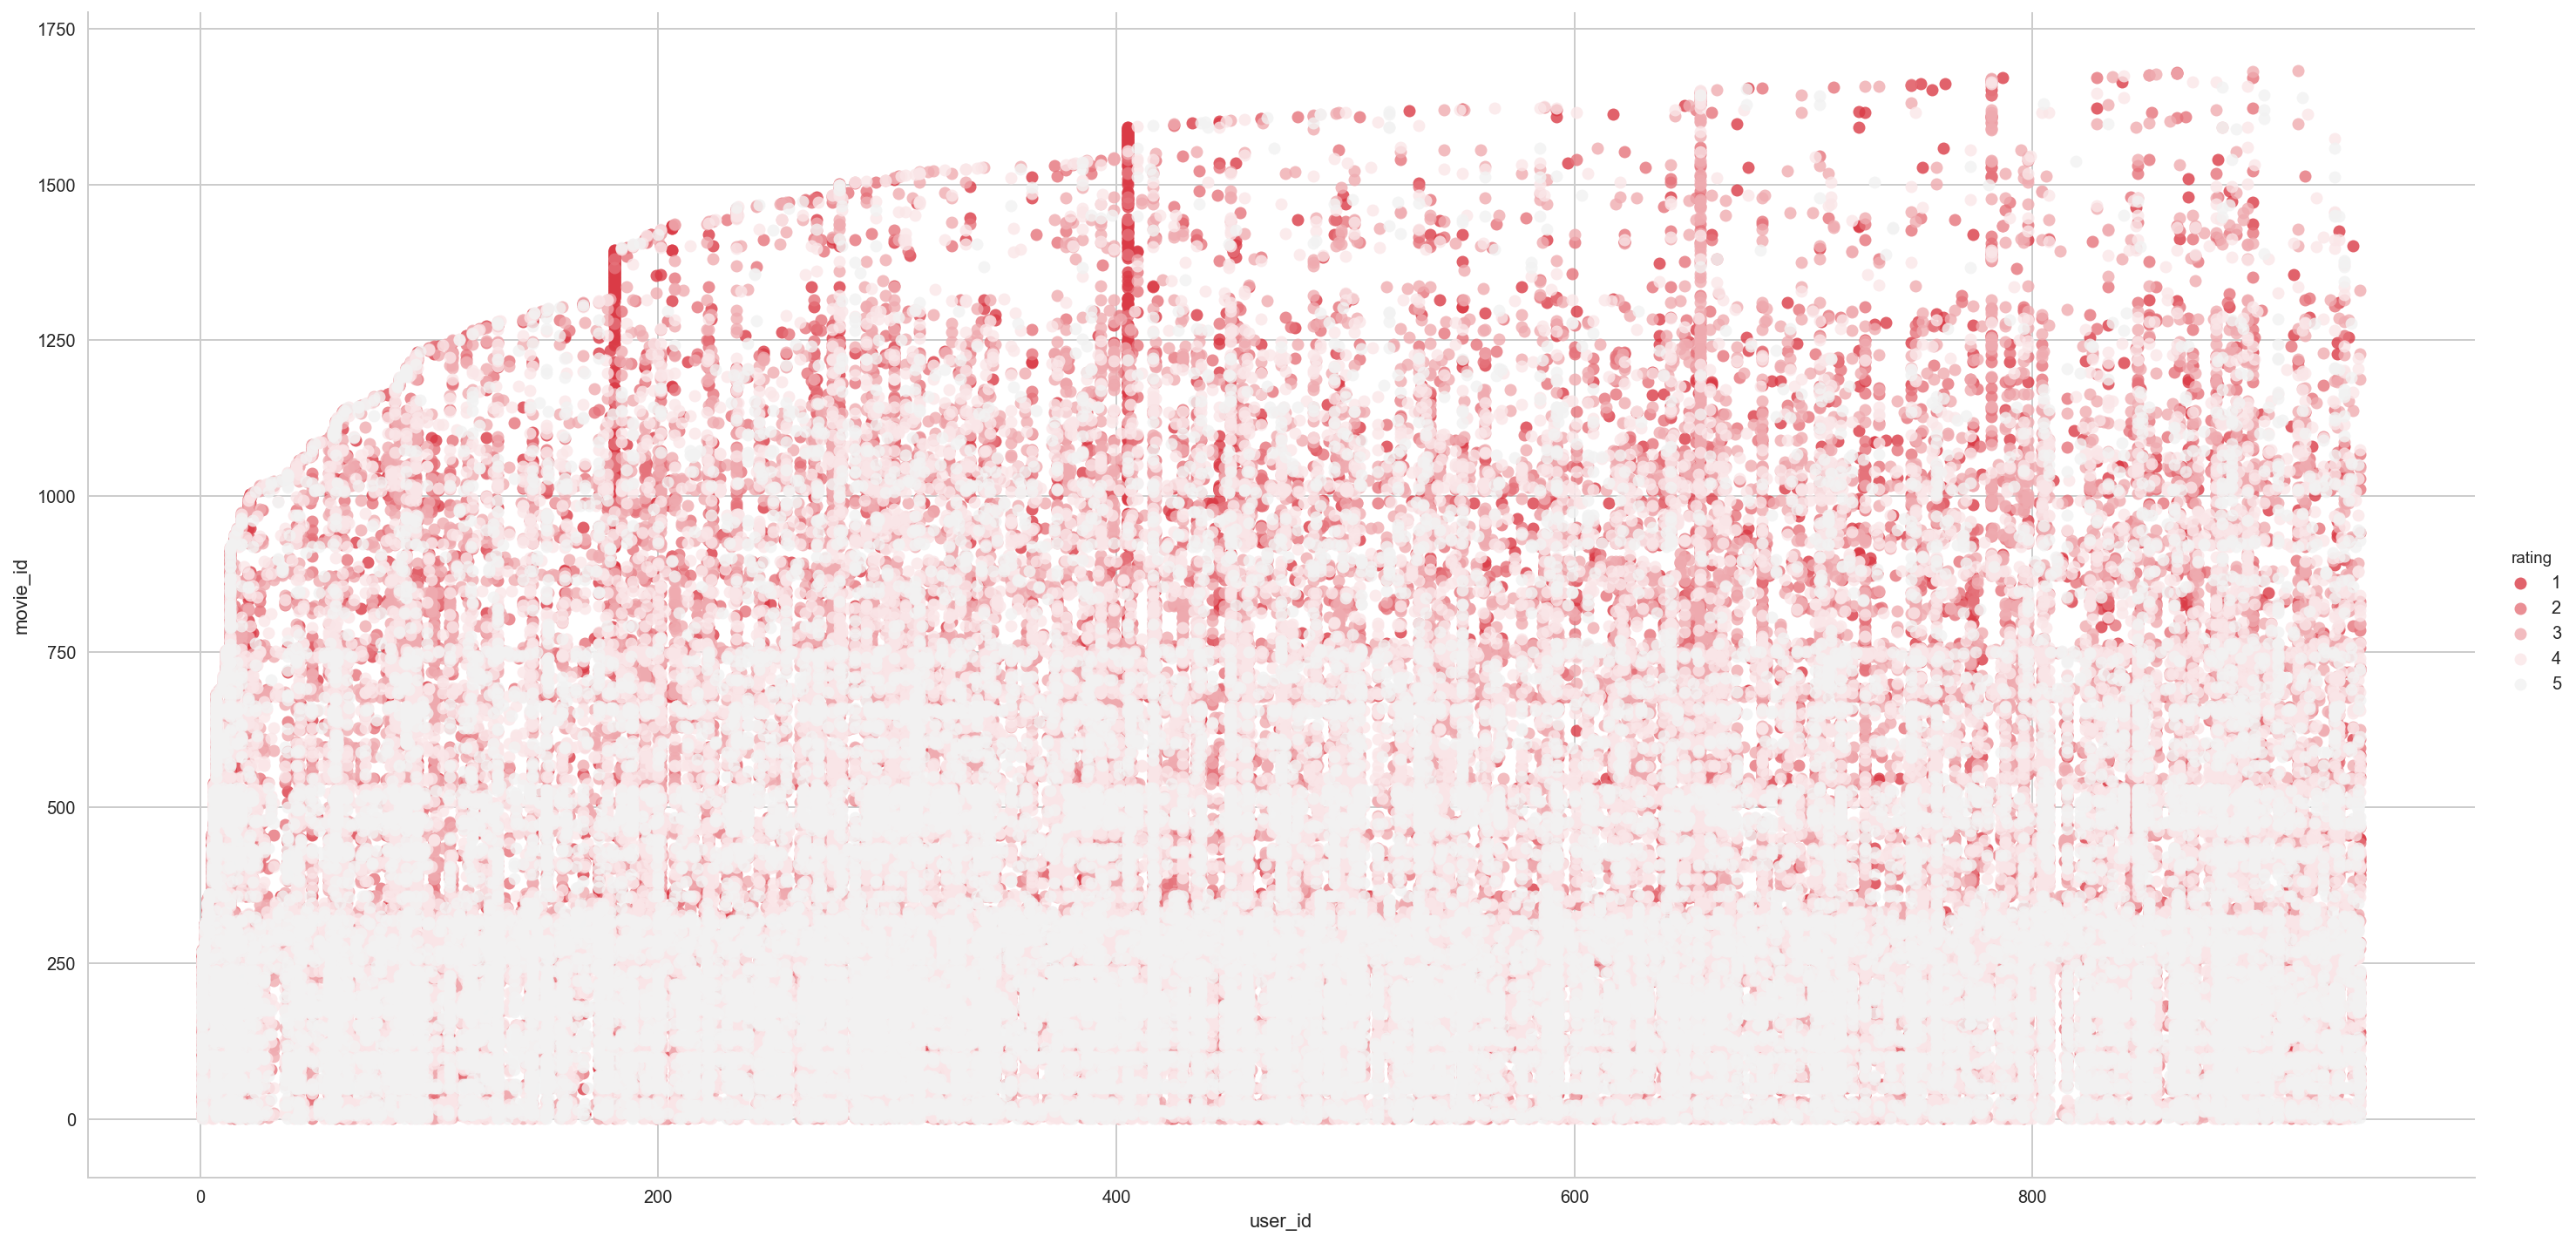

In [26]:
lm = sns.lmplot(x='user_id', y='movie_id', hue='rating', data=ratings_df.toPandas(), fit_reg=False, size=10, aspect=2, palette=sns.diverging_palette(10, 133, sep=80, n=10))
#axes = lm.axes
#axes[0,0].set_ylim(0,1682) # max movieId is 1682
#axes[0,0].set_xlim(0,943) # max userId is 943
#lm

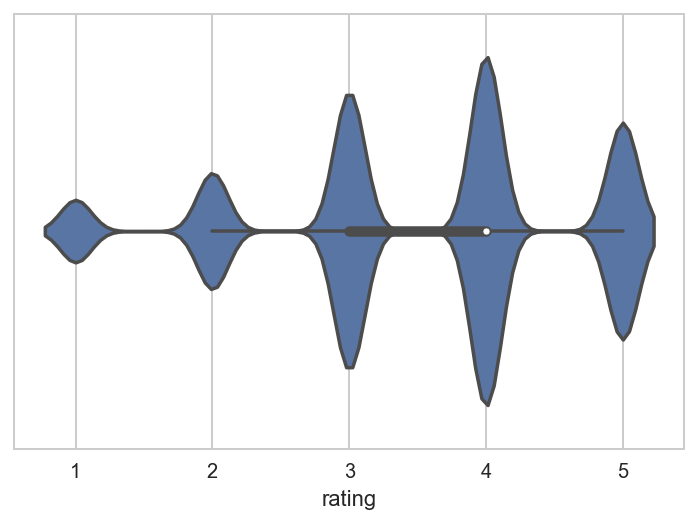

In [27]:
sns.violinplot(ratings_df.toPandas()['rating'])

## 5. Build the recommender system

There are different methods for building a recommender system, such as, user-based, content-based, or collaborative filtering. Collaborative filtering calculates recommendations based on similarities between users and products. For example, collaborative filtering assumes that users who give the similar ratings on the same movies will also have similar opinions on movies that they haven't seen.

The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous ratings.

In this case, the ALS algorithm will create a matrix of all users versus all movies. Most cells in the matrix will be empty. An empty cell means the user hasn't reviewed the movie yet. The ALS algorithm will fill in the probable (predicted) ratings, based on similarities between user ratings. The algorithm uses the least squares computation to minimize the estimation errors, and alternates between solving for movie factors and solving for user factors.

The following trivial example gives us an idea of the problem to solve. However, keep in mind that the general problem is much harder because the matrix often has far more missing values.

![](assets/als.png)

In [28]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

Check the size of the ratings matrix:

In [29]:
spark.sql(strip_margin(
                    """SELECT *, 100 * nb_ratings/matrix_size AS percentage
                      |FROM (
                      |    SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
                      |    FROM (
                      |        SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movie_id)) AS nb_movies, COUNT(DISTINCT(user_id)) AS nb_users
                      |        FROM ratings
                      |    )
                      |)
                    """)).show(truncate=False)

+--------+---------+----------+-----------+-----------------+
|nb_users|nb_movies|nb_ratings|matrix_size|percentage       |
+--------+---------+----------+-----------+-----------------+
|943     |1682     |100000    |1586126    |6.304669364224532|
+--------+---------+----------+-----------+-----------------+



Less than 6% of the matrix is filled.

### 5.1. Split the data set into training and test set

To accurately evaluate the model, it's common practice in machine learning to split the data set between a training data set to train the model, and a test data set to compare the predicted results with the original results. This process is called cross-validation. Not doing cross-validation often leads to overfitting, which occurs when the model is too specific to the training data set and does not perform well on a more general data set. Here's the general iterative process of machine learning:

![](assets/machine-learning.png)

In [30]:
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=rnd_seed)

In [31]:
# we will cache the data because we will be using this dataframes over and over again
train_df.cache()
test_df.cache()

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

### 5.2 Build the ALS Model

In [32]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank=10, maxIter=10, regParam=0.01, userCol='user_id', itemCol='movie_id', ratingCol='rating', coldStartStrategy="drop", seed=rnd_seed)

In [33]:
model = als.fit(train_df)

**Latent Factors for the Users:**

In [34]:
# How many latent factors for users
model.userFactors.show(10, 100)

+---+----------------------------------------------------------------------------------------------------+
| id|                                                                                            features|
+---+----------------------------------------------------------------------------------------------------+
| 10|[-0.6030998, -0.41528544, 0.44101703, -0.6747683, -0.092831284, 0.52737844, 0.28389353, 0.8892376...|
| 20|[-0.7826431, -0.20276727, 0.76003516, -0.24733657, 0.6590504, 1.8141851, -1.2167426, 1.0126661, -...|
| 30|[0.09419747, -1.0783802, 0.6628187, -0.74109995, 0.041222006, 0.22821158, 0.6336942, 0.81336284, ...|
| 40|[-0.92254233, -0.19851889, 1.2706549, 0.4585579, 0.7865489, -0.16955793, 0.8354432, -0.079133384,...|
| 50|[-0.4015326, -0.73014057, -0.35344702, -2.0134468, 2.8497427, 0.21825986, -0.78548336, -0.7743276...|
| 60|[-0.5744309, -0.7272041, 0.16464917, -0.74626726, 0.0050338563, 0.78069776, -0.0049148123, 0.6945...|
| 70|[-0.35054162, -0.4342798, 0.7004

In [35]:
# How many users
model.userFactors.count()

943

**Latent Factors for the Movies:**

In [36]:
# How many latent factors for items
model.itemFactors.show(10, 100)

+---+----------------------------------------------------------------------------------------------------+
| id|                                                                                            features|
+---+----------------------------------------------------------------------------------------------------+
| 10|[-0.61359376, -0.7665692, -0.11454323, -0.65134436, 0.8113621, 1.9789561, 1.2655749, 0.56401765, ...|
| 20|[-0.34660864, -0.5121295, 0.50613683, -0.059631106, -0.7979815, 2.4832695, 0.6548208, 1.252404, 0...|
| 30|[0.07013116, -1.428627, 0.24895814, -0.27081984, 0.09670849, 0.98023313, 1.171251, 0.67392135, 1....|
| 40|[-1.2737969, -0.5023049, 0.7017578, -0.9633071, 0.9976688, 1.6293999, 0.03657924, -0.059141457, 0...|
| 50|[-0.9753693, -0.65629214, 0.51041555, -0.5237083, -0.15679596, 1.1654347, 0.7373897, 1.3229154, 1...|
| 60|[-0.72699225, -2.0345035, -0.95745677, -0.8026362, 0.26603928, 1.8658394, 0.95187676, 0.21342973,...|
| 70|[-0.29884276, -1.1341875, 0.7441

In [37]:
# How many Movies
model.itemFactors.count()

1655

In [38]:
# How may Latent Factors?
model.rank

10

### 5.3 Cross Validated Model

The hyperparameters for the ALS algorithm are:

`rank` = the number of latent factors in the model  
`maxIter` = the maximum number of iterations  
`regParam` = the regularization parameter  

To test several values for those **`hyperparameters`** and choose the best configuration, it's common practice to define a grid of parameter combinations and to run a **`grid search`** over the combinations to evaluate the resulting models and comparing their performance. This process is known as **`model selection`**.

The Spark `CrossValidator` function performs a grid search as well as k-fold cross validation. We run the CrossValidator function with multiple values for `rank` and `regParam`:

In [39]:
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop", seed=rnd_seed)

In [40]:
paramGrid = (ParamGridBuilder()
             .addGrid(als.rank, [1, 5, 10])
             .addGrid(als.maxIter, [20])
             .addGrid(als.regParam, [0.05, 0.1, 0.5])
             .build())

In [41]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')

In [42]:
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

In [43]:
cvModel = crossval.fit(train_df)

In [44]:
best_model = cvModel.bestModel

## 6. Generate Predictions

In [49]:
test_df.sample(fraction=0.01).limit(10).show(10)

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|     20|     357|     1|
|     48|     174|     5|
|     93|     283|     4|
|    178|      62|     4|
|    181|     277|     1|
|    244|     118|     2|
|    272|     204|     4|
|    279|     429|     4|
|    379|     151|     4|
|    401|     663|     1|
+-------+--------+------+



In [186]:
movie_rating_preds = cvModel.transform(test_df)

In [187]:
movie_rating_preds.show(10)

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    633|     148|     1| 3.3062713|
|    406|     148|     3| 2.5702705|
|     44|     148|     4| 3.0148978|
|    271|     148|     3| 2.6472085|
|    916|     148|     2|  2.327694|
|    330|     148|     4| 4.2056255|
|    372|     148|     5|  3.988464|
|    164|     148|     5| 4.1740923|
|    430|     148|     2| 2.9503698|
|    347|     148|     3|  2.812393|
+-------+--------+------+----------+
only showing top 10 rows



**Check if any predictions are beyond the boundaries of 1.0 to 5.0:**

In [188]:
movie_rating_preds.filter("prediction < 1.0 or prediction > 5.0").show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    330|     496|     5| 5.1880116|
|    405|    1591|     1|0.08139682|
|    626|     243|     1| 0.7009436|
|     13|     858|     1| 0.8263675|
|    405|     858|     1| 0.6587153|
|    206|     362|     1|0.69820815|
|    181|     976|     1|0.84129035|
|    206|     683|     1| 0.7309355|
|    803|     688|     1|  0.867217|
|    688|     332|     5|  5.419031|
|    747|     192|     5| 5.0055084|
|    724|     908|     1|0.95966977|
|    472|      12|     5|  5.041092|
|    372|      12|     4| 5.0721984|
|    264|      12|     5|  5.039331|
|    206|     336|     1|0.98123413|
|    617|     860|     1| 0.7758959|
|    372|     333|     5|  5.003174|
|    181|    1215|     1|0.72984195|
|    472|      22|     5| 5.1111875|
+-------+--------+------+----------+
only showing top 20 rows



**Clip predictions values between 1.0 to 5.0:**

In [189]:
movie_rating_preds = (movie_rating_preds
                      .withColumn("prediction", 
                                  F.when(col("prediction") > 5.0, 5.0)
                                  .when(col("prediction") < 1.0, 1.0)
                                  .otherwise(col("prediction")))
                     )

In [190]:
# recheck if there any any ou tof bound values
movie_rating_preds.filter("prediction < 1.0 or prediction > 5.0").show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
+-------+--------+------+----------+



In [191]:
movie_rating_preds.printSchema()

root
 |-- user_id: short (nullable = true)
 |-- movie_id: short (nullable = true)
 |-- rating: byte (nullable = true)
 |-- prediction: double (nullable = false)



In [192]:
movie_rating_preds = (movie_rating_preds
                      .withColumn("prediction_rounded", F.rint('prediction').cast(FloatType()))
                      .withColumn("rating", col('rating').cast(FloatType()))
                     )
movie_rating_preds.cache()

DataFrame[user_id: smallint, movie_id: smallint, rating: float, prediction: double, prediction_rounded: float]

In [193]:
movie_rating_preds.show(10)

+-------+--------+------+------------------+------------------+
|user_id|movie_id|rating|        prediction|prediction_rounded|
+-------+--------+------+------------------+------------------+
|    633|     148|   1.0|3.3062713146209717|               3.0|
|    406|     148|   3.0| 2.570270538330078|               3.0|
|     44|     148|   4.0|3.0148978233337402|               3.0|
|    271|     148|   3.0|2.6472084522247314|               3.0|
|    916|     148|   2.0|2.3276939392089844|               2.0|
|    330|     148|   4.0| 4.205625534057617|               4.0|
|    372|     148|   5.0| 3.988464117050171|               4.0|
|    164|     148|   5.0|4.1740922927856445|               4.0|
|    430|     148|   2.0|2.9503698348999023|               3.0|
|    347|     148|   3.0|2.8123929500579834|               3.0|
+-------+--------+------+------------------+------------------+
only showing top 10 rows



### Evaluate the Predictions

In [194]:
RMSE = evaluator.evaluate(movie_rating_preds)

In [195]:
print("Root Mean Squared Error = {0}".format(RMSE))

Root Mean Squared Error = 0.915490972730125


In [196]:
# RMSE with rating rounded column
RegressionEvaluator(predictionCol='prediction_rounded', labelCol='rating', metricName='rmse').evaluate(movie_rating_preds)

0.9615471820573427

In [197]:
from pyspark.mllib.evaluation import RankingMetrics, RegressionMetrics

In [199]:
perUserActual = (movie_rating_preds
                 .where(col("rating") > 2.5)
                 .groupBy("user_id")
                 .agg(F.collect_set("movie_id").alias("movies")))


In [200]:
perUserActual.show()

+-------+--------------------+
|user_id|              movies|
+-------+--------------------+
|    148|[596, 238, 194, 5...|
|    463|[270, 151, 866, 9...|
|    833|[234, 205, 32, 24...|
|    496|[132, 509, 206, 5...|
|    897|[763, 742, 183, 2...|
|    243|[1148, 15, 458, 7...|
|    623|[183, 659, 50, 22...|
|    540|[628, 332, 9, 101...|
|    737|[12, 32, 475, 258...|
|    392|[248, 328, 663, 1...|
|    858|[9, 292, 307, 286...|
|     31|[306, 321, 611, 1...|
|    516|[212, 357, 902, 191]|
|    137|[1, 249, 300, 118...|
|    251|[520, 12, 742, 24...|
|     85|[204, 1039, 357, ...|
|    580|[222, 1, 121, 866...|
|    451|[749, 304, 330, 9...|
|    808|[748, 288, 750, 2...|
|     65|[15, 661, 356, 16...|
+-------+--------------------+
only showing top 20 rows



In [206]:
perUserPredictions = (movie_rating_preds
                 .orderBy(["user_id", "prediction"], ascending=[True, False])
                 .groupBy("user_id")
                 .agg(F.collect_set("movie_id").alias("movies")))


In [207]:
perUserPredictions.show()

+-------+--------------------+
|user_id|              movies|
+-------+--------------------+
|    148|[596, 238, 50, 19...|
|    463|[930, 1, 270, 952...|
|    496|[509, 132, 496, 2...|
|    833|[234, 205, 32, 24...|
|    243|[1148, 15, 458, 7...|
|    392|[538, 248, 300, 3...|
|    540|[628, 9, 332, 101...|
|    623|[183, 659, 815, 2...|
|    737|[12, 32, 475, 258...|
|    858|[9, 292, 307, 286...|
|    897|[763, 204, 183, 7...|
|     31|[611, 306, 321, 1...|
|    516|[212, 357, 902, 191]|
|     85|[51, 204, 357, 10...|
|    137|[1, 249, 300, 118...|
|    251|[520, 12, 748, 74...|
|    451|[269, 880, 749, 2...|
|    580|[748, 281, 222, 1...|
|    808|[748, 288, 750, 2...|
|     65|[15, 661, 655, 16...|
+-------+--------------------+
only showing top 20 rows



In [208]:
perUserActualvPred = (perUserActual.join(perUserPredictions, ["user_id"])
                      .rdd
                      .map(lambda row: (row[1], row[2][:15])))

In [209]:
ranks = RankingMetrics(perUserActualvPred)

In [210]:
ranks.meanAveragePrecision

0.81633957895584

In [211]:
ranks.precisionAt(5)

0.8893662728249193

### Top 3 Movie Recommendations for All Users

In [88]:
# top 3 movies recommended for each user
user_recs = best_model.recommendForAllUsers(3)

In [89]:
user_recs.show(truncate=False)

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|471    |[[1427, 6.0082016], [791, 5.8416195], [1260, 5.7979503]]|
|463    |[[1463, 4.7686205], [1405, 4.4288416], [851, 4.3830566]]|
|833    |[[1368, 4.94519], [838, 4.865925], [1022, 4.5914392]]   |
|496    |[[838, 5.4060917], [1368, 4.8610272], [913, 4.6490254]] |
|148    |[[1463, 5.73514], [793, 5.5052724], [851, 5.447281]]    |
|540    |[[1463, 5.199136], [1643, 5.151386], [1467, 5.0165462]] |
|392    |[[1463, 5.8495564], [1643, 5.603627], [1449, 5.187183]] |
|243    |[[1233, 5.0253367], [1463, 4.7096753], [1642, 4.691521]]|
|623    |[[1463, 5.35004], [1643, 5.0895214], [814, 4.9015727]]  |
|737    |[[838, 5.269891], [1405, 5.1649275], [1536, 4.9984355]] |
|897    |[[1643, 5.345831], [1467, 5.2489576], [1450, 5.224677]] |
|858    |[[838, 5.239607], [913, 4.703555], [1639, 4.637379]] 

In [90]:
# python trick to display data types inside the dataframe
user_recs

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

**Reshape the movie_id and rating arrays into columns for an user:**

In [110]:
user_recs_one = user_recs.where(user_recs.user_id == 1).cache()

In [111]:
user_recs_one

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

In [113]:
user_recs_one.show(truncate=False)

+-------+-----------------------------------------------------+
|user_id|recommendations                                      |
+-------+-----------------------------------------------------+
|1      |[[1463, 5.39971], [1643, 5.185261], [1405, 5.097198]]|
+-------+-----------------------------------------------------+



In [112]:
user_recs_one.select("user_id", "recommendations.movie_id", "recommendations.rating").collect()

[Row(user_id=1, movie_id=[1463, 1643, 1405], rating=[5.399710178375244, 5.185260772705078, 5.097198009490967])]

In [114]:
user_recs_one.select("user_id", "recommendations.movie_id", "recommendations.rating").show()

+-------+------------------+--------------------+
|user_id|          movie_id|              rating|
+-------+------------------+--------------------+
|      1|[1463, 1643, 1405]|[5.39971, 5.18526...|
+-------+------------------+--------------------+



**Reshape using a Sequence Id (Join Using monotonically_increasing_id()):**

In order to join the recommended movies and recommended ratings we need to introduce an additional id column. In order to ensure that the values in the id column is increasing we use the monotonically_increasing_id() function. This function is guaranteed to produce increasing numbers but not guaranteed to produce sequential increasing numbers if there are more than 1 partition in the dataframe. So we also repartition the exploded dataframe into 1 partition.

In [116]:
only_movies = user_recs_one.select("user_id", F.explode(col("recommendations.movie_id")).alias("movie_id"))
only_movies = only_movies.repartition(1).withColumn('id', F.monotonically_increasing_id())
only_movies = only_movies.select('id', 'user_id', 'movie_id')
only_movies.show()

+---+-------+--------+
| id|user_id|movie_id|
+---+-------+--------+
|  0|      1|    1463|
|  1|      1|    1643|
|  2|      1|    1405|
+---+-------+--------+



In [117]:
only_ratings = user_recs_one.select("user_id", F.explode(col("recommendations.rating")).alias("rating"))
only_ratings = only_ratings.repartition(1).withColumn('id', F.monotonically_increasing_id())
only_ratings = only_ratings.select('id', 'user_id', 'rating')
only_ratings.show()

+---+-------+--------+
| id|user_id|  rating|
+---+-------+--------+
|  0|      1| 5.39971|
|  1|      1|5.185261|
|  2|      1|5.097198|
+---+-------+--------+



In [118]:
only_movies.join(only_ratings.drop('user_id'), on='id', how='inner').drop('id').show()

+-------+--------+--------+
|user_id|movie_id|  rating|
+-------+--------+--------+
|      1|    1463| 5.39971|
|      1|    1643|5.185261|
|      1|    1405|5.097198|
+-------+--------+--------+



**Reshape without using a Sequence Id:**

We can do the same thing as above even without using a id column. All we need to do is to explode the struct column and then select the sub fields of the struct column.

In [122]:
(user_recs_one
 .select("user_id", F.explode("recommendations").alias("reco"))).show()

+-------+----------------+
|user_id|            reco|
+-------+----------------+
|      1| [1463, 5.39971]|
|      1|[1643, 5.185261]|
|      1|[1405, 5.097198]|
+-------+----------------+



Although, the explode("recommendations") is now generated as "reco" we can still access subfields of that struct column. This information is hiddent inside the column metadata.

In [123]:
(user_recs_one
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+--------+
|user_id|movie_id|  rating|
+-------+--------+--------+
|      1|    1463| 5.39971|
|      1|    1643|5.185261|
|      1|    1405|5.097198|
+-------+--------+--------+



In [ ]:
user_recs_one.unpersist()

### Top 3 Movie Recommendations for a Particular User

**Filter out the user we are interested from the set of all predictions:**

In [124]:
user_recs.where(user_recs.user_id == 2).show(truncate=False)

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|2      |[[1463, 5.3024673], [1643, 5.243119], [1449, 5.0017676]]|
+-------+--------------------------------------------------------+



**Create a subset user dataframe and invoke `recommendForUserSubset` on the model:**

In [125]:
user_subset = ratings_df.where(ratings_df.user_id == 2)

In [128]:
user_subset.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      2|     237|     4|
|      2|     316|     5|
|      2|     100|     5|
|      2|     286|     4|
|      2|     274|     3|
|      2|      19|     3|
|      2|     294|     1|
|      2|     306|     4|
|      2|     308|     3|
|      2|     293|     4|
|      2|      25|     4|
|      2|     307|     3|
|      2|     275|     5|
|      2|     290|     3|
|      2|     298|     3|
|      2|     276|     4|
|      2|     283|     5|
|      2|     300|     4|
|      2|      14|     4|
|      2|     296|     3|
+-------+--------+------+
only showing top 20 rows



In [126]:
user_subset_recs = best_model.recommendForUserSubset(user_subset, 3)

In [130]:
user_subset_recs.show(truncate=False)

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|2      |[[1463, 5.3024673], [1643, 5.243119], [1449, 5.0017676]]|
+-------+--------------------------------------------------------+



In [127]:
(user_subset_recs
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      2|    1463|5.3024673|
|      2|    1643| 5.243119|
|      2|    1449|5.0017676|
+-------+--------+---------+



### Top 3 User Recommendations for All Movies

In [131]:
# top 3 users recommended for each movie, for all movies.
movie_recs = best_model.recommendForAllItems(3)

In [132]:
movie_recs.show(truncate=False)

+--------+------------------------------------------------------+
|movie_id|recommendations                                       |
+--------+------------------------------------------------------+
|1580    |[[434, 1.282814], [127, 1.2495224], [340, 1.1834537]] |
|471     |[[688, 5.1008577], [849, 4.9136972], [507, 4.7074094]]|
|1591    |[[258, 5.3392053], [88, 5.2970195], [427, 5.212144]]  |
|1342    |[[34, 4.2800756], [88, 4.27962], [4, 4.201245]]       |
|463     |[[341, 4.715106], [274, 4.7109814], [310, 4.71029]]   |
|833     |[[127, 4.236563], [677, 4.215074], [887, 4.1570263]]  |
|496     |[[152, 5.3846626], [849, 5.3808703], [688, 5.330821]] |
|148     |[[688, 4.8704696], [849, 4.7821193], [507, 4.7246575]]|
|1088    |[[471, 4.559013], [36, 4.335021], [261, 4.106742]]    |
|1238    |[[261, 4.7444787], [427, 4.6631002], [519, 4.4872026]]|
|540     |[[688, 3.9301784], [849, 3.7362227], [732, 3.6282246]]|
|1460    |[[810, 3.7461796], [808, 3.7434096], [928, 3.654272]] |
|392     |

### Top 3 User Recommendations for a Particular Movie

**Filter out the movie we are interested from the set of all predictions:**

In [140]:
movie_recs_one = movie_recs.where(movie_recs.movie_id == 36).cache()

In [141]:
movie_recs_one.show(truncate=False)

+--------+------------------------------------------------------+
|movie_id|recommendations                                       |
+--------+------------------------------------------------------+
|36      |[[688, 3.2813184], [849, 3.1357331], [810, 3.1355648]]|
+--------+------------------------------------------------------+



In [142]:
movie_recs_one.select("recommendations.user_id", "recommendations.rating").collect()

[Row(user_id=[688, 849, 810], rating=[3.281318426132202, 3.135733127593994, 3.1355648040771484])]

**Create a subset movie dataframe and invoke `recommendForItemSubset` on the model:**

In [136]:
movie_subset = ratings_df.where(ratings_df.movie_id == 36)

In [143]:
movie_subset.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|    256|      36|     3|
|    201|      36|     1|
|    796|      36|     1|
|    477|      36|     4|
|    293|      36|     1|
|    393|      36|     3|
|    314|      36|     2|
|    405|      36|     2|
|      1|      36|     2|
|    846|      36|     2|
|    655|      36|     2|
|    184|      36|     3|
|    416|      36|     2|
+-------+--------+------+



In [137]:
movie_subset_recs = best_model.recommendForItemSubset(movie_subset, 3)

In [138]:
movie_subset_recs.select("movie_id", "recommendations.user_id", "recommendations.rating").show(truncate=False)

+--------+---------------+---------------------------------+
|movie_id|user_id        |rating                           |
+--------+---------------+---------------------------------+
|36      |[688, 849, 810]|[3.2813184, 3.1357331, 3.1355648]|
+--------+---------------+---------------------------------+



In [139]:
(movie_subset_recs
 .select("movie_id", F.explode("recommendations").alias("reco"))
 .select("movie_id", "reco.user_id", "reco.rating")).show()

+--------+-------+---------+
|movie_id|user_id|   rating|
+--------+-------+---------+
|      36|    688|3.2813184|
|      36|    849|3.1357331|
|      36|    810|3.1355648|
+--------+-------+---------+



### Predict Rating for a Particular User and a Particular Movie

In [145]:
from pyspark.sql import Row
test_user_movie_df = spark.createDataFrame([Row(user_id=789, movie_id=123)], ['user_id', 'movie_id'])

In [146]:
test_user_movie_df.show()

+-------+--------+
|user_id|movie_id|
+-------+--------+
|    123|     789|
+-------+--------+



**Predict Rating:**

In [149]:
best_model.transform(test_user_movie_df).show()

+-------+--------+----------+
|user_id|movie_id|prediction|
+-------+--------+----------+
|    123|     789|  3.538966|
+-------+--------+----------+



### Generate top 10 Recommendations for User 789:

In [150]:
from pyspark.sql import Row
test_user_df = spark.createDataFrame([Row(user_id=789)], ['user_id'])

In [151]:
test_user_df.show()

+-------+
|user_id|
+-------+
|    789|
+-------+



In [152]:
test_user_recs = best_model.recommendForUserSubset(test_user_df, 10).cache()

In [154]:
test_user_recs.select("user_id", "recommendations.movie_id", "recommendations.rating").show()

+-------+--------------------+--------------------+
|user_id|            movie_id|              rating|
+-------+--------------------+--------------------+
|    789|[1368, 1643, 1104...|[5.2748294, 5.179...|
+-------+--------------------+--------------------+



In [155]:
(test_user_recs
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|    789|    1368|5.2748294|
|    789|    1643| 5.179338|
|    789|    1104| 5.147609|
|    789|     838|5.0126486|
|    789|    1589| 4.987554|
|    789|    1467| 4.966961|
|    789|    1022|4.8493237|
|    789|     320| 4.735556|
|    789|    1448|  4.67183|
|    789|     641|4.6650724|
+-------+--------+---------+



**Combine genre information with the recommendations:**

In [157]:
movie_genres = (['unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 
                 'fantasy', 'filmnoir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western'])

In [158]:
# An utility function to combine all active genres of the movie into an array
from numpy import ma
def combine_genres(genres):
    x = ma.masked_array(movie_genres, mask=(1 - np.array(genres)))
    return x[~x.mask].data.tolist()

In [159]:
combine_genres([0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0])

['adventure', 'comedy', 'documentary', 'fantasy', 'mystery', 'scifi', 'war']

In [160]:
udf_combine_genres = udf(lambda genres: combine_genres(genres), ArrayType(elementType=StringType()))

**Retrieve top 10 Movies predicted for User 789:**

In [168]:
print('Recommended Top 10 Movies For User 789:')
(test_user_recs
 .select('user_id', F.explode(col("recommendations")).alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")
 .join(movies_df, on=['movie_id'], how='inner')
 .withColumn('genres', udf_combine_genres(F.array('unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmnoir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western')))
 .select('user_id', 'movie_id', F.round('rating', 0).alias('rating'), 'title', 'genres')
 .orderBy(F.desc('rating'), 'movie_id')
).show(truncate=False)

Recommended Top 10 Movies For User 789:
+-------+--------+------+-----------------------------------------------------------+----------------------+
|user_id|movie_id|rating|title                                                      |genres                |
+-------+--------+------+-----------------------------------------------------------+----------------------+
|789    |320     |5.0   |Paradise Lost: The Child Murders at Robin Hood Hills (1996)|[documentary]         |
|789    |641     |5.0   |Paths of Glory (1957)                                      |[drama, war]          |
|789    |838     |5.0   |In the Line of Duty 2 (1987)                               |[action]              |
|789    |1022    |5.0   |Fast, Cheap & Out of Control (1997)                        |[documentary]         |
|789    |1104    |5.0   |C'est arriv� pr�s de chez vous (1992)                      |[comedy, crime, drama]|
|789    |1368    |5.0   |Mina Tannenbaum (1994)                                     |[dr

**Retrieve top 10 Movies rated by User 789:**

In [165]:
sqlContext.udf.register("sql_udf_combine_genres", combine_genres, ArrayType(elementType=StringType()))

<function __main__.combine_genres>

In [169]:
# Top 10 movies rated by user 789
print('Top 10 Rated Movies by User 789:')
spark.sql(strip_margin(
                    """SELECT r.user_id, r.movie_id, cast(r.rating as float), m.title, sql_udf_combine_genres(array(unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, filmnoir, horror, musical, mystery, romance, scifi, thriller, war, western)) as genres
                      |FROM ratings r, movies m
                      |WHERE r.user_id = 789
                      |AND r.movie_id = m.movie_id
                      |ORDER BY r.rating DESC, r.movie_id 
                      |LIMIT 10
                    """)).show(truncate=False)

Top 10 Rated Movies by User 789:
+-------+--------+------+-------------------------------+----------------------------------------+
|user_id|movie_id|rating|title                          |genres                                  |
+-------+--------+------+-------------------------------+----------------------------------------+
|789    |9       |5.0   |Dead Man Walking (1995)        |[drama]                                 |
|789    |50      |5.0   |Star Wars (1977)               |[action, adventure, romance, scifi, war]|
|789    |100     |5.0   |Fargo (1996)                   |[crime, drama, thriller]                |
|789    |127     |5.0   |Godfather, The (1972)          |[action, crime, drama]                  |
|789    |129     |5.0   |Bound (1996)                   |[crime, drama, romance, thriller]       |
|789    |150     |5.0   |Swingers (1996)                |[comedy, drama]                         |
|789    |276     |5.0   |Leaving Las Vegas (1995)       |[drama, romance]   

Comparing the Recommendations with the Movies that the user already Rated with high rating it appears he likes movies around 1995 time frame and of genre Drama. He also likes movies of genre romance and thriller but they are not recommended.

In [212]:
spark.stop()